In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from astropy.io import fits
import os

import plotting
import auxil_ML as aux

In [32]:
save_plots = 1
#bins = {}
#bins_dict['AGN'] = np.linspace(-10.5, -7, 19)
#bins_dict['PSR'] = np.linspace(-10, -6.5, 19)
bins = np.linspace(-9.5, -7, 15)
binsc = (bins[1:] + bins[:-1])/2

#alg0 = 'NN_O'
alg0 = 'LR'

folder = '../SOM'
pcat_df_dict = {}
cats = ['3FGL', '4FGL-DR2']
pops = ['AGN', 'PSR', 'OTHER']

for cat in cats:
    for nclass in [2, 3]:
        key = '%s_%iclass' % (cat, nclass)
        cat_fn = '%s/%s_prob_catalog_%iclasses.csv' % (folder, cat, nclass)
        pcat_df_dict[key] = pd.read_csv(cat_fn, index_col=0)
#print(pcat_df_dict['4FGL'].columns)

In [33]:
masks = {}
for cat in cats:
    for nclass in [2, 3]:
        cat_key = '%s_%iclass' % (cat, nclass)
        cat0 = cat.replace('-DR2', '')
        masks[cat_key] = {}
        pcat_df = pcat_df_dict[cat_key]
        masks[cat_key]['AGN'] = (pcat_df['Category_%s' % cat0] == 'AGN')
        masks[cat_key]['PSR'] = (pcat_df['Category_%s' % cat0] == 'PSR')
        masks[cat_key]['OTHER'] = (pcat_df['Category_%s' % cat0] == 'OTHER')
        masks[cat_key]['ASSOC'] = (pcat_df['Category_%s' % cat0] != 'UNAS')
        masks[cat_key]['UNAS'] = (pcat_df['Category_%s' % cat0] == 'UNAS')
    
    

In [34]:
fn_cats = {}
fn_cats['3FGL'] = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
fn_cats['4FGL'] = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
fn_cats['4FGL-DR2'] = '../PS_comparison/gll_psc_v27.fit' # 4FGL_DR2

fgl_dfs = {}
for cat in cats:
    nclass = 2
    key = '%s_%iclass' % (cat, nclass)
    hdu_cat = fits.open(fn_cats[cat])
    # transform hdu table to dataframe
    fgl_df0 = aux.hdu2df(hdu_cat[1], index_name='Source_Name') 
    # remove sources with missing values
    fgl_dfs[cat] = fgl_df0.loc[pcat_df_dict[key].index] 

In [35]:
quantity = 'Flux1000'
hists = {}
hist_other = {}
hist_unas = {}
eps = 0.00001
for cat in cats:
    for nclass in [2, 3]:
        cat_key = '%s_%iclass' % (cat, nclass)
        df_fgl = fgl_dfs[cat]
        pcat_df = pcat_df_dict[cat_key]
        df_fgl['value'] = np.log10(np.array(df_fgl[quantity]))
        hists[cat_key] = {}
        for key in ['AGN', 'PSR', 'ASSOC', 'UNAS', 'OTHER']:
            hists[cat_key][key] = np.histogram(df_fgl['value'][masks[cat_key][key]], bins=bins)[0]

        other_values = df_fgl['value'][masks[cat_key]['OTHER']]
        unas_values = df_fgl['value'][masks[cat_key]['UNAS']]
        hist_other[cat_key] = {}
        hist_unas[cat_key] = {}
        hist_unas[cat_key]['OTHER_corr'] = 0.
        for key in ['AGN', 'PSR', 'OTHER'][:nclass]:
            label = '%s_%s' % (key, alg0)
            other_probs = pcat_df[label][masks[cat_key]['OTHER']]
            unas_probs = pcat_df[label][masks[cat_key]['UNAS']]
            hist_other[cat_key][key] = np.histogram(other_values, bins=bins, weights=other_probs)[0]
            hist_unas[cat_key][key] = np.histogram(unas_values, bins=bins, weights=unas_probs)[0]
            if nclass == 2:
                other_corr = hist_other[cat_key][key]/(hists[cat_key]['ASSOC'] + eps) * hists[cat_key]['UNAS']
                hist_unas[cat_key]['OTHER_corr'] += other_corr
            else:
                other_corr = 0.
            hist_unas[cat_key][key + '_corr'] = hist_unas[cat_key][key] - other_corr
            if 0:
                print(cat, key)                        
                print(hist_other[cat_key][key])
                print(hists[cat_key]['ASSOC'])
                print(hists[cat_key]['UNAS'])
                print(other_corr)


Save figure to file: plots/N_logS_diff_AGN.pdf
cp plots/N_logS_diff_AGN.pdf ../ML_3FGL_paper/plots
cp plots/N_logS_diff_AGN.pdf ../ML_3FGL_paper_AA_style/plots
Save figure to file: plots/N_logS_diff_PSR.pdf
cp plots/N_logS_diff_PSR.pdf ../ML_3FGL_paper/plots
cp plots/N_logS_diff_PSR.pdf ../ML_3FGL_paper_AA_style/plots
Save figure to file: plots/N_logS_diff_OTHER.pdf
cp plots/N_logS_diff_OTHER.pdf ../ML_3FGL_paper/plots
cp plots/N_logS_diff_OTHER.pdf ../ML_3FGL_paper_AA_style/plots


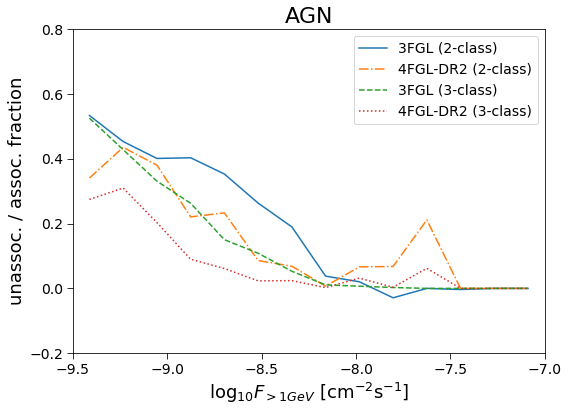

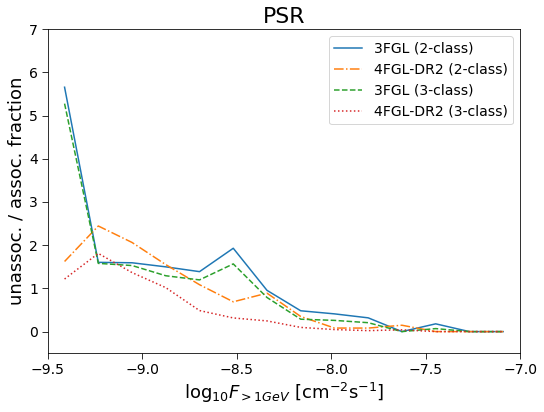

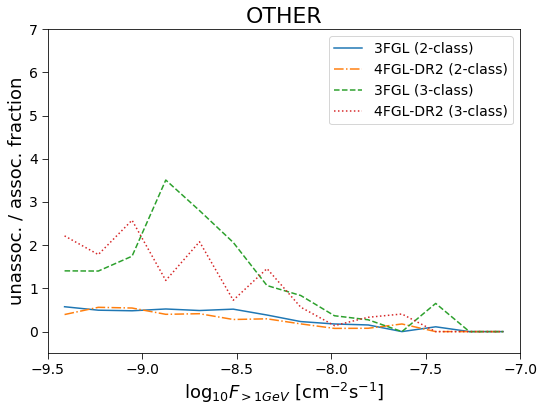

In [36]:
plotting.setup_figure_pars()
eps = 1.e-10
lss = {'3FGL_2class':'-', '4FGL-DR2_2class':'-.', '3FGL_3class':'--', '4FGL-DR2_3class':':'}
for pop in pops:
    pyplot.figure()
    for nclass in [2, 3]:
        for cat in cats:
            cat_key = '%s_%iclass' % (cat, nclass)
            
            if not (nclass == 2 and pop == 'OTHER') or True:
                ys = hist_unas[cat_key][pop + '_corr'] / (hists[cat_key][pop] + eps)
                #print(pop, cat, ys)
                pyplot.plot(binsc, ys, ls=lss[cat_key], label='%s (%i-class)' % (cat, nclass))

    pyplot.legend()

    pyplot.xlabel(r'$\log_{10} F_{>1 GeV}\ [\rm cm^{-2}s^{-1}]$')
    pyplot.ylabel('unassoc. / assoc. fraction')
    pyplot.ylim(0, 10)
    pyplot.legend()
    title = pop
    pyplot.title(title)
    pyplot.xlim(bins[0], bins[-1])
    if pop == 'AGN':
        pyplot.ylim(-0.2, 0.8)
    elif pop == 'PSR':
        pyplot.ylim(-0.5, 7)
    elif pop == 'OTHER':
        pyplot.ylim(-0.5, 7)
    #pyplot.grid()
    
    if save_plots:
        figfn_diff = 'plots/N_logS_diff_%s.pdf' % pop
        print('Save figure to file:', figfn_diff)
        pyplot.savefig(figfn_diff)
        cmd = 'cp %s ../ML_3FGL_paper/plots' % figfn_diff
        print(cmd)
        os.system(cmd)
        cmd = 'cp %s ../ML_3FGL_paper_AA_style/plots' % figfn_diff
        print(cmd)
        os.system(cmd)


In [37]:
for cat in cats:
    for nclass in [2, 3]:
        cat_key = '%s_%iclass' % (cat, nclass)

        print('%s, %i-class' % (cat, nclass))
        print(hists[cat_key]['UNAS'])
        print(hists[cat_key]['OTHER'])
        print(hist_unas[cat_key]['OTHER_corr'])


3FGL, 2-class
[213 166 120 100  61  53  33  13   6   4   0   1   0   0]
[ 5  9 13  9 10 11 15  8  9  7  8  1  4  1]
[2.8783783  4.45970136 6.26505999 4.71204164 4.87999961 5.71568571
 5.75581328 1.85714253 1.58823483 1.07692266 0.         0.11111099
 0.         0.        ]
3FGL, 3-class
[213 166 120 100  61  53  33  13   6   4   0   1   0   0]
[ 5  9 13  9 10 11 15  8  9  7  8  1  4  1]
[ 7.02889317 12.61435397 22.68479281 31.57433765 28.00974769 22.70453488
 15.98895787  6.68609779  3.30180818  1.91348072  0.          0.6524875
  0.          0.        ]
4FGL-DR2, 2-class
[224 221 173  88  70  44  29  10   4   2   3   0   0   0]
[24 45 32 42 23 42 15 14 19  5  6  2  4  0]
[ 9.48148131 25.30534287 17.46372185 16.79999924  9.52662666 11.77069989
  4.43877506  2.49999955  1.40740715  0.38461524  1.05882291  0.
  0.          0.        ]
4FGL-DR2, 3-class
[224 221 173  88  70  44  29  10   4   2   3   0   0   0]
[24 45 32 42 23 42 15 14 19  5  6  2  4  0]
[53.17724734 80.24266331 82.5092024